<a href="https://colab.research.google.com/github/antbartash/muffins/blob/main/muffins.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
from torchvision import datasets, models, transforms
import os
import time
import copy

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Data and transforms

In [6]:
data_dir = 'drive/MyDrive/Muffins/data'

data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.RandomVerticalFlip(),
        transforms.ToTensor(),
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor()
    ])
}

image_datasets = {
    x: datasets.ImageFolder(os.path.join(data_dir, x),
                            data_transforms[x])
    for x in ['train', 'val']
}

dataloaders = {
    x: torch.utils.data.DataLoader(image_datasets[x], batch_size=32, 
                                   num_workers=4, shuffle=True)
    for x in ['train', 'val']
}

dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [7]:
class_names

['chihuahua', 'muffin']

# Sample images

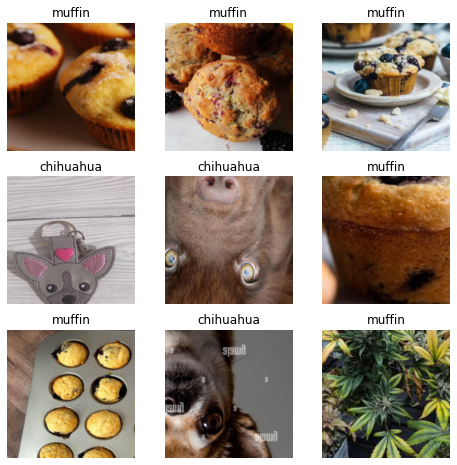

In [8]:
plt.figure(figsize=(8, 8))
for i in range(1, 10):
  img_batch, label_batch = next(iter(dataloaders['train']))
  img = img_batch[0].numpy().transpose((1, 2, 0))
  label = label_batch[0]
  ax = plt.subplot(3, 3, i)
  plt.title(class_names[label])
  plt.axis('off')
  plt.imshow(img)
plt.show()

# Train model

In [9]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
  since = time.time()

  best_model_wts = copy.deepcopy(model.state_dict())
  best_acc = 0.0

  for epoch in range(num_epochs):
    print(f'Epoch {epoch}/{num_epochs - 1}')
    print('-' * 10)

    for phase in ['train', 'val']:
      if phase == 'train':
        model.train() # set model to training mode
      else:
        model.eval() # set model to eval mode
      
      running_loss = 0.0
      running_corrects = 0

      # Iterate over data
      for inputs, labels in dataloaders[phase]:
        inputs = inputs.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()

        # forward step
        # Context-manager that sets gradient calculation to on or off
        with torch.set_grad_enabled(phase == 'train'):
          outputs = model(inputs)
          _, preds = torch.max(outputs, 1)
          loss = criterion(outputs, labels)

          # backward step
          if phase == 'train':
            loss.backward()
            optimizer.step()
        
        # statistics
        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
      
      if phase == 'train':
        scheduler.step()
      
      epoch_loss = running_loss / dataset_sizes[phase]
      epoch_acc = running_corrects.double() / dataset_sizes[phase]
      print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

      # deep copy the model
      if phase == 'val' and epoch_acc > best_acc:
        best_acc = epoch_acc
        best_model_wts = copy.deepcopy(model.state_dict())
    
    print()

  time_elapsed = time.time() - since
  print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
  print(f'Best val Acc: {best_acc:4f}')

  # load best model weights
  model.load_state_dict(best_model_wts)
  return model

# Visualizing the model predictions

In [21]:
def visualize_predictions(model, num_images=6):
  was_training = model.training
  model.eval()
  images_so_far = 0
  fig = plt.figure()

  with torch.no_grad():
    for i, (inputs, labels) in enumerate(dataloaders['val']):
      inputs = inputs.to(device)
      labels = labels.to(device)

      outputs = model(inputs)
      _, preds = torch.max(outputs, 1)

      for j in range(inputs.size()[0]):
        images_so_far += 1
        ax = plt.subplot(num_images//2, 2, images_so_far)
        ax.axis('off')
        ax.set_title(f'{class_names[preds[j]]}')
        img = inputs.cpu().data[j].numpy().transpose((1, 2, 0))
        plt.imshow(img)

        if images_so_far == num_images:
          model.train(mode=was_training)
          return
    model.train(model=was_training)

# Finetuning the convnet

In [11]:
from torch.optim import lr_scheduler
model_ft = models.resnet18(pretrained=True)
num_ftrs = model_ft.fc.in_features

model_ft.fc = torch.nn.Linear(num_ftrs, 2)
model_ft = model_ft.to(device)

criterion = torch.nn.CrossEntropyLoss()

# all parameters are being optimized
optimizer_ft = torch.optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

# Train and evaluate

In [12]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=25)

Epoch 0/24
----------
train Loss: 0.1289 Acc: 0.9493
val Loss: 0.0190 Acc: 0.9958

Epoch 1/24
----------
train Loss: 0.0674 Acc: 0.9734
val Loss: 0.0146 Acc: 0.9949

Epoch 2/24
----------
train Loss: 0.0595 Acc: 0.9772
val Loss: 0.0113 Acc: 0.9975

Epoch 3/24
----------
train Loss: 0.0552 Acc: 0.9784
val Loss: 0.0112 Acc: 0.9966

Epoch 4/24
----------
train Loss: 0.0432 Acc: 0.9839
val Loss: 0.0083 Acc: 0.9992

Epoch 5/24
----------
train Loss: 0.0414 Acc: 0.9848
val Loss: 0.0071 Acc: 0.9975

Epoch 6/24
----------
train Loss: 0.0364 Acc: 0.9875
val Loss: 0.0059 Acc: 0.9983

Epoch 7/24
----------
train Loss: 0.0336 Acc: 0.9861
val Loss: 0.0062 Acc: 0.9966

Epoch 8/24
----------
train Loss: 0.0377 Acc: 0.9844
val Loss: 0.0065 Acc: 0.9975

Epoch 9/24
----------
train Loss: 0.0401 Acc: 0.9846
val Loss: 0.0061 Acc: 0.9975

Epoch 10/24
----------
train Loss: 0.0388 Acc: 0.9856
val Loss: 0.0062 Acc: 0.9966

Epoch 11/24
----------
train Loss: 0.0339 Acc: 0.9871
val Loss: 0.0064 Acc: 0.9966

Ep

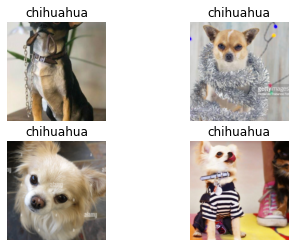

In [24]:
visualize_predictions(model_ft, 4)

# Test